# Two Step Task 
 - This notebook simulate the two step task of a agent, store all the Data of the simulation and plot the Stay Probability

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [3]:
def update_data_frame(df): 
    # this funcation add to the data frame 3 columns:
    # 1 - prev_reward : if the last trail was rewarded
    # 2 - transation_prev : if the last transation was common or rare
    # 3 - stay probs 
    
    df['prev_reward'] = df['reward'].shift(1,fill_value=0)
    df['transation_prev'] = df['transation_type'].shift(1,fill_value=0)
    df['stay'] = df['action_statge_1'].shift(1) == df['action_statge_1']

def calc_stay_probs(df): 
    # this funcation retuen a new df of stay prob according to every 
    # combination of reward/transation 4 option
    
    return df.groupby(['prev_reward', 'transation_prev'])['stay'].mean().reset_index()
    
def plot_stay_probs(list_of_stay):
    # this funcation plots the stay probs given a list of the stay probs
    # each element of the list represents combination of transation/reward
    # list_of_stay[0] -> rare/unrewarded | list_of_stay [1] -> common/unrewarded
    # list_of_stay[2] -> rare/rewarded | list_of_stay [3] -> common/rewarded
    
    x_labels = ['Rewarded' ,'Unrewarded']
        
    common = [list_of_stay[3],list_of_stay[1]]
    rare = [list_of_stay[2],list_of_stay[0]]
    
    # the width of the bars
    widthB = 0.35  
    r1 = np.arange(len(x_labels))
    r2 = [i + widthB for i in r1]
    
    fig , ax = plt.subplots()

    ax.bar(r1,common, color='blue', width=widthB, edgecolor='white', label='Common')
    ax.bar(r2, rare, color='red', width=widthB, edgecolor='white', label='Rare')

    ax.set_ylabel('Stay Probability',size=12)
    ax.set_title('PLOT',size=14)
    ax.set_xticks([((2*r + widthB)/2) for r in range(len(x_labels))])
    ax.set_xticklabels(x_labels,size=12)
    ax.set_ylim((0, 1))  
    ax.legend()

    fig.tight_layout()
    
    return ax
    
def calc_main_effect(list_of_stay):
     # this funcation retuen the main effect of stay prob
    return ((list_of_stay[3] + list_of_stay[2])/2) - ((list_of_stay[1] +list_of_stay[0])/2)

def calc_interaction_effect(list_of_stay):
    # this funcation retuen the interaction effect of stay prob
    return (list_of_stay[3] - list_of_stay[2]) - (list_of_stay[1] - list_of_stay[0])


In [4]:
class DataOfSim():
    
    # this class stores all the data of one simulation
    # storing the following: action_1, stage_2_state, transation_type, action_2, reward
    def __init__ (self , num_of_trails):
        self.action_1_list = np.zeros(num_of_trails)
        self.stage_2_state = np.zeros(num_of_trails)
        self.transation_list = ['' for i in range(num_of_trails)]
        self.action_2_list = np.zeros(num_of_trails)
        self.reward_list = np.zeros(num_of_trails) 
    
    def createDic(self):
        dic = {
                'action_statge_1' : self.action_1_list,
                'transation_type' : self.transation_list,
                'action_stage_2' : self.action_2_list, 
                'state_of_stage_2' : self.stage_2_state,
                'reward' : self.reward_list
        }

        return dic    

In [5]:
# configuration of all parameters

# set num of trails
num_of_trails = 6000

# set num of action 
action_space = 2

# set num of states 
state_space = 2

# set num of stages 
stages_space = 2

# q_values of model free
q_mf = np.zeros(shape = (action_space ,state_space, stages_space))

# q_values of model based
q_mb = np.zeros(action_space)

# the weighted sum of model-based and model-free values
q_net = np.zeros(2)

# set learning rate - α  
alpha_1 = 0.7

# set discounting factor - γ 
gamma = 1

# set beta temperature - β (for sowftMax)
beta = 2

# weighting parameter 
# w = 1 -> MB ; w = 0 -> MF
w = 1

# state transition structure 
transition_prob = np.array(
                            [[.7,.3],
                            [.3,.7]]
)


expected_reward = np.array(
                            [[.8,.5],
                            [.5,.8]]
)

# store data from each trail 
data = DataOfSim(num_of_trails)

In [6]:
# utility funcation used for the q-learning

def sowftmax(beta, q):
    return (np.exp(q * beta)) / sum(np.exp(q * beta))

def prediction_error(a , b): return a-b

def update_q_table(q_table, reward, alpha, gamma = 1):
    q_table[action] = q_table[action] + gamma * \
                                                (alpha * (prediction_error(reward,q_table[action])))
def calculate_q_net(w, q_mb, q_mf):
    return (w * q_mb) + ((1-w) * q_mf)

def configuration_parameters():
    pass

In [7]:
# set to 1 to print step by step trail 
PRINT_EACH_TRAIL = 0

for t in range(num_of_trails):
    # this funcation simalate an agent playing the two step task num_of_trails times 
    # if PRINT_EACH_TRAIL is set to 1 this funcation will output evrey trail 

    if PRINT_EACH_TRAIL: print("----- Trail = {} -----".format(t))

    # Q_model-based values of the first level actions (Bellman’s equation)
    q_mb[0] = (transition_prob[0,0]*np.max(q_mf[:,0,1])) + (transition_prob[0,1]*np.max(q_mf[:,1,1]))
    q_mb[1] = transition_prob[1,0] * np.max(q_mf[:,0,1]) + transition_prob[1,1] * np.max(q_mf[:,1,1])
    if PRINT_EACH_TRAIL: print("Q_MB = {}".format(q_mb))

    # net action values at the first stage as the weighted sum of model-based and model-free values
    q_net[0] = calculate_q_net(w,q_mb[0],q_mf[0,0,0])
    q_net[1] = calculate_q_net(w,q_mb[1],q_mf[1,0,0])

    # calc prob with sowftMax for first stage
    prob = sowftmax(beta,q_net)[0]
    if PRINT_EACH_TRAIL: print("Prob 1 = {}".format(prob))

    # choose action_1 according to prob for first stage
    action_1 = np.random.choice([0,1] , p = [prob,1-prob])
    data.action_1_list[t] = action_1
    if PRINT_EACH_TRAIL: print("Action 1 = {}".format(action_1))

    # transation to second stage 
    state = np.random.choice([0,1], p = [transition_prob[action_1,0], 1 - transition_prob[action_1,0]])
    transation = 1 if action_1 == state else 0
    data.stage_2_state[t] = state
    data.transation_list[t] = 1 if transation == 1 else 0
    if PRINT_EACH_TRAIL: print("Transation to State = {}".format(state))
    if PRINT_EACH_TRAIL: print("Transation type = {}".format('Common' if transation == 1 else 'Rare'))

    # calc prob with sowftMax for second stage
    prob = sowftmax(beta,q_mf[:,state,1])[0]
    if PRINT_EACH_TRAIL: print("Prob 2 = {}".format(prob))

    # choose action_2 according to prob for second stage
    action_2 = np.random.choice([0,1] ,p = [prob, 1 - prob])
    data.action_2_list[t] = action_2
    if PRINT_EACH_TRAIL: print("Action 2 = {}".format(action_1))

    # cheek if the trail is rewarded
    reward = np.random.choice([0,1] , p = [1-expected_reward[state,action_2], expected_reward[state,action_2]])
    data.reward_list[t] = reward
    if PRINT_EACH_TRAIL: print("Reward = {}".format('YES!' if reward == 1 else 'NO'))

    # calculate prediction error
    p_e_1 = prediction_error(q_mf[action_2,state,1],q_mf[action_1,0,0])
    p_e_2 = prediction_error(reward,q_mf[action_2,state,1])
    if PRINT_EACH_TRAIL: print("Prediction Error first = {}".format(p_e_1))
    if PRINT_EACH_TRAIL: print("Prediction Error second = {}".format(p_e_2))

    # update q_mf according to q_learning formula
    q_mf[action_1,0,0] = q_mf[action_1,0,0] + alpha_1 * p_e_1 + gamma * (alpha_1 * p_e_2)
    q_mf[action_2,state,1] = q_mf[action_2,state,1] + alpha_1 * p_e_2

    if PRINT_EACH_TRAIL: print("Q_MF = {}".format(q_mf))
    if PRINT_EACH_TRAIL : input('PRESS ENTER FOR NEXT TRAIL')


df = pd.DataFrame(data.createDic())

The avarge rewared is = 0.6958333333333333


,action_statge_1,transation_type,action_stage_2,state_of_stage_2,reward,prev_reward,transation_prev,stay
0,0.0,1,0.0,0.0,1.0,0.0,0,False
1,0.0,0,0.0,1.0,1.0,1.0,1,True
2,0.0,1,0.0,0.0,1.0,1.0,0,True
3,1.0,1,0.0,1.0,1.0,1.0,1,False
4,1.0,0,0.0,0.0,1.0,1.0,1,True


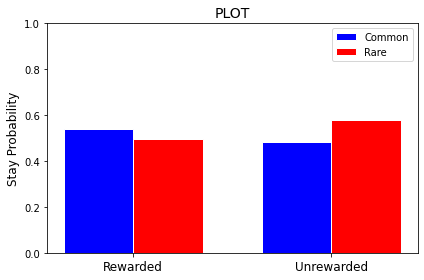

In [8]:
print("The avarge rewared is = {}".format(df['reward'].mean()))
update_data_frame(df)
stay_prob_df = calc_stay_probs(df)
plot = plot_stay_probs(stay_prob_df['stay'].tolist())
df.head()

In [ ]:
def param_recovary(paramters, df):
    
    ll = 0 
    q_table = np.zeros(2)

    num_trials = len(df)
    action_1 = list(map(int, df['action_statge_1']))
    action_2 = list(map(int, df['action_stage_2']))
    reward = list(map(int, df['reward'])) 
    p_choice= np.zeros(num_trials)
    
    beta = paramters[0]
    alpha = paramters[1]

    for t in range(num_trials):
        p_choice[t] = np.exp(beta * q_table[action[t]]) / sum(np.exp(beta*q_table))
        p_e = reward[t] - q_table[action[t]]
        q_table[action[t]] = q_table[action[t]] + alpha*p_e

    ll = -(sum(np.log(p_choice)))
    return ll

def fit_to_min(param):
    return param_recovary(param,df)

minimize(fit_to_min,[1,0.5],method = 'Nelder-Mead')